# Real-World Applications of _pandas_ and _Scikit-Learn_: Predicting San Diego Housing Prices Based on Census Tract Data

Joel Rosenthal, Benjamin Llanes, Shannon McAndrews, Crystal Li

## Introduction and Background

### Background and Prior Work

Gentrification has major impacts on the communities it impacts. Predicting gentrification is of interest to members of the community, activists, and those interested in real estate. Governing magazine released a report on gentrification in the 50 largest US Cities, and UC Berkeley has launched the Urban Displacement Project to research gentrification in the Bay Area. Researchers have used past census data, crime data, and even social media data to predict gentrification in certain cities. Even building permit data has been postulated as a potential cause of gentrification.
	We intend to use a combination of factors, some of which have been researched and others which haven’t, in order to predict gentrification in San Diego. Work into this field is just beginning and we hope to provide a novel perspective. While some of these approaches have been used individually, we intend to combine them with building permit data, which has only been suggested, and gentrification in surrounding areas, which is novel. In addition, none of this work has attempted to predict gentrification in San Diego. As residents of San Diego, it is of particular interest to us to explain and predict the changes we are currently witnessing.

References (include links):
- 1) Gentrification in America Report
http://www.governing.com/gov-data/gentrification-in-cities-governing-report.html
- 2) The Urban Displacement Project
http://www.urbandisplacement.org/research
- 3) Can We Predict Gentrification?
https://www.handhousing.org/can-we-predict-gentrification/
- 4) Predicting gentrification using longitudinal census data
http://urbanspatialanalysis.com/portfolio/predicting-gentrification-using-longitudinal-census-data/
- 5) Predicting gentrification through social networking data
https://www.cam.ac.uk/research/news/predicting-gentrification-through-social-networking-data
- 6) Has Falling Crime Invited Gentrification?
http://furmancenter.org/research/publication/has-falling-crime-invited-gentrification
- 7) How to predict rising home prices, neighborhood change and gentrification
https://www.washingtonpost.com/news/wonk/wp/2015/08/04/how-to-predict-rising-home-prices-and-future-gentrification/

Unforunately, the extent of gentrification remains difficult to judge directly, and the lack of an official list of census tracts to have been gentrified makes it difficult to be able to use Machine Learning models to predict gentrification as a classification problem. Therefore, we decided to measure gentrification indirectly by taking a look at increasing housing prices as a function of metrics, which include white vs. minority population, criminal incidents, etc. We believe that if there is a high correlation between these metrics and increasing housing prices, then housing prices can be looked at in determining whether or not a tract is considered to be at risk of gentrification.

### Research Question

Can we use publicly available data to construct a model that accurately predicts housing prices in the tracts of San Diego County? More specifically, how well will metrics such as percent white population and percent male education predict housing prices in a given San Diego Census Tract?

### Hypothesis 
We hypothesize that the various metrics measured in our data will be effective as predictors of past housing prices and San Diego County. We predict that high counts of building permits, lower crime rates, and higher population of white residents will be factors that correlate with (but not conclusively cause) higher housing prices.

## Data Description

### Datasets

- Dataset Name: County of San Diego-PDS BLDS Building Permits
- Link to the dataset:	http://www.civicdata.com/dataset/permit_standard_permits_xml_10306/resource/7f84606c-57c4-4821-a43b-bf18408c111b
- Number of observations: 89,914

Status history for permits issued by Planning and Development Services in San Diego County since 2005 (updated daily)

- Dataset Name: San Diego Region Crime Incidents 2007 - 2013
- Link to the dataset: http://data.sandiegodata.org/dataset/clarinova_com-crime-incidents-casnd-7ba4-extract
- Number of observations: 1,008,524

Geocoded crime incidents from 1 Jan 2007 to 31 March 2013 based on data supplied by SANDAG

- Dataset Name: 2012-2016 American Community Survey 5-Year Estimates
- Link to the dataset: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_5YR_DP05&prodType=table
- Number of observations: 1,103,128

Age and sex, total population, race, median home value, median household income, and educational attainment for all census tracts within within San Diego County, California

- Dataset Name: SANGIS Census Regions
- Link to the dataset: http://data.sandiegodata.org/lv/dataset/sangis-org-census_regions-2010-sandiego-3
- Number of observations: N/A

San Diego Census Tract Boundaries

#### Combining Datasets
We will use the SANGIS Census Regions to map the latitude and longitude from the Building Permits and Crime datasets onto census tracts. Then we will merge those datasets with the ACS data by census tracts.  

## Data Cleaning/Pre-Processing
- To create the dataset to be used for training our regression classifier for predicting housing prices, there are 3 main datasets that we must clean and pre-process:
    - The _County of San Diego - PDS BLDS Building Permits_ dataset.
    - The _San Diego Region Crime Incidents, 2007 - 2013_ dataset.
    - The _American Community Survey, 5-Year Estimates_ dataset.
- The data cleaning for each of these datasets will be detailed below in their own respective sections.

In [3]:
# core imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# machine learning imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

# for mapping latitude and longitude coords to census tract
from shapely.geometry import shape, Point, Polygon
from shapely.wkt import loads
from rtree import index

# used for some string matching
import re

# for checking if cached data exists before recalculating
import os.path

# Improve readability
import warnings
warnings.filterwarnings("ignore")

### ACS Dataset Cleaning (Joel Rosenthal)
- Fortunately, the ACS Dataset comes in a simple-to-parse format. For each data set, which corresponds to a given year and given metric, simply contains the values of each metric for each San Diego County Census Tract. 
- We need to do some transformations for some of our metrics. For example, to find the _percentage_\__male_ metric (which also gives percentage female), we need to divide the male population by the total poplation to yield a column that is the population percentage that is male.
    - Other transformations like this will be detailed below.
- Some of the code below is commented out because of a bug in the Anaconda Version that this notebook was compiled using that does not let it run, but we keep it here for documentation purposes. The DataFrame that results from this code can be seen later in the _Data Cleaning_ section, where we merge the results with the result from cleaning the Crime and Building permit datasets.

In [13]:
df = pd.DataFrame()

for year in range(2007, 2015):
  
    # All filepaths for the all datasets for the current year
    ACS_agesex_filepath = f'./Datasets/ACS {year-2}-{year+2}/ACS_{year+2-2000:02}_5YR_S0101_with_ann.csv'
    ACS_sex_filepath = f'./Datasets/ACS {year-2}-{year+2}/ACS_{year+2-2000:02}_5YR_S0101_with_ann.csv'
    ACS_age_filepath = f'./Datasets/ACS {year-2}-{year+2}/ACS_{year+2-2000:02}_5YR_B01002_with_ann.csv'
    ACS_race_filepath = f'./Datasets/ACS {year-2}-{year+2}/ACS_{year+2-2000:02}_5YR_B02001_with_ann.csv'
    ACS_homevalue_filepath = f'./Datasets/ACS {year-2}-{year+2}/ACS_{year+2-2000:02}_5YR_B25077_with_ann.csv'
    ACS_income_filepath = f'./Datasets/ACS {year-2}-{year+2}/ACS_{year+2-2000:02}_5YR_B19013_with_ann.csv'
    ACS_employment_filepath = f'./Datasets/ACS {year-2}-{year+2}/ACS_{year+2-2000:02}_5YR_S2301_with_ann.csv'
    ACS_education_filepath = f'./Datasets/ACS {year-2}-{year+2}/ACS_{year+2-2000:02}_5YR_S1501_with_ann.csv'

    # read all the files into respective DataFrames
    ACS_sex_df = pd.read_csv(open(ACS_sex_filepath))
    ACS_age_df = pd.read_csv(open(ACS_age_filepath))
    ACS_race_df = pd.read_csv(open(ACS_race_filepath))
    ACS_homevalue_df = pd.read_csv(open(ACS_homevalue_filepath))
    ACS_income_df = pd.read_csv(open(ACS_income_filepath))
    ACS_employment_df = pd.read_csv(open(ACS_employment_filepath))
    ACS_education_df = pd.read_csv(open(ACS_education_filepath))

    # drop all columns besides the Census Tract and the metric corresponding to the
    # DataFrame
    
    # for sex/gender metric, we need both the male population and the total population
    ACS_sex_df = ACS_sex_df[['GEO.display-label', 'HC01_EST_VC01', 'HC02_EST_VC01']]
    ACS_age_df = ACS_age_df[['GEO.display-label', 'HD01_VD02']]
    ACS_race_df = ACS_race_df[['GEO.display-label', 'HD01_VD02']]
    ACS_homevalue_df = ACS_homevalue_df[['GEO.display-label', 'HD01_VD01']]
    ACS_income_df = ACS_income_df[['GEO.display-label', 'HD01_VD01']]
    ACS_employment_df = ACS_employment_df[['GEO.display-label','HC04_EST_VC01']]
    
    # some education metric corner cases
    if year == 2007:
        ACS_education_df = ACS_education_df[['GEO.display-label','HC01_EST_VC15']]
    elif year < 2013:
        ACS_education_df = ACS_education_df[['GEO.display-label','HC01_EST_VC17']]
    else:
        ACS_education_df = ACS_education_df[['GEO.display-label','HC02_EST_VC18']]

    # merge all metric DataFrames, building rows corresponding to each
    # Census Tract
    df_year = pd.merge(ACS_sex_df, ACS_age_df, on='GEO.display-label')
    df_year = pd.merge(df_year, ACS_race_df, on='GEO.display-label')
    df_year = pd.merge(df_year, ACS_homevalue_df, on='GEO.display-label')
    df_year = pd.merge(df_year, ACS_income_df, on='GEO.display-label')
    df_year = pd.merge(df_year, ACS_employment_df, on='GEO.display-label')
    df_year = pd.merge(df_year, ACS_education_df, on='GEO.display-label')

    # finalize the columns that we want
    df_year.columns = ['tract', 'pop', 'male_pop', 'age', 'white_pop', 'homeval', 'income', 'unemployment', 'pct_bachelors']

    # drop all unentered/unknown values
    df_year.drop(0, axis=0, inplace=True)
    
    # create a column for only the year
    df_year['year'] = year
    
    # add the DataFrame we just created to the final DataFrame
    df = pd.concat([df, df_year], axis=0)
    
df.head()

,tract,pop,male_pop,age,white_pop,homeval,income,unemployment,pct_bachelors,year
1,"Census Tract 1, San Diego County, California",3165,1507,48.8,3060,"1,000,000+",112065,4.1,60.9,2007
2,"Census Tract 2, San Diego County, California",6117,3125,41.3,5483,672200,56563,3.4,57.5,2007
3,"Census Tract 3, San Diego County, California",5279,2499,43.3,4333,559400,60769,5.8,51.2,2007
4,"Census Tract 4, San Diego County, California",3401,1905,36.2,2593,557000,49320,7.2,60.7,2007
5,"Census Tract 5, San Diego County, California",2727,1477,40.4,2345,669300,60213,6.0,50.6,2007


#### ACS Dataset Cleaning: Transforming Our Metrics
- Now that we have a rough version of our ACS Dataset, we apply our transformations on the DataFrame to get our metrics in the form needed for training on our Machine Learning model later.
- The _simplify_\__tract_ function extracts the Census Tract ID from the long Census Tract string present in the original dataset
- We also provide standard values for missing data in the form of _np.nan_.
- All columns must also be converted to floats so that they can be used in the regression algorithm.
- For the _percent_\__white_ and _percent_\__male_ metrics, we simply divide the male population and white population by the total population, then add the result in its separate column.
- Finally, we drop all unneeded columns in preparation for merging with the crime and building permit data set to be parsed afterwards.

In [14]:
def simplify_tract(tract):
    tract = tract.replace('Census Tract', '')
    tract = tract.replace(', San Diego County, California', '')
    tract = tract.strip()
    return tract

df['tract'] = df['tract'].apply(simplify_tract)

df.loc[df['age'] == '-', 'age'] = np.nan
df.loc[df['homeval'] == '-', 'homeval'] = np.nan
df.loc[df['homeval'] == '1,000,000+', 'homeval'] = 1000000
df.loc[df['homeval'] == '2,000,000+', 'homeval'] = 2000000
df.loc[df['income'] == '-', 'income'] = np.nan
df.loc[df['pct_bachelors'] == '-', 'pct_bachelors'] = np.nan
df.loc[df['unemployment'] == '-', 'unemployment'] = np.nan

df['pop'] = df['pop'].astype(float)
df['male_pop'] = df['male_pop'].astype(float)
df['age'] = df['age'].astype(float)
df['white_pop'] = df['white_pop'].astype(float)
df['homeval'] = df['homeval'].astype(float)
df['income'] = df['income'].astype(float)
df['unemployment'] = df['unemployment'].astype(float)
df['pct_bachelors'] = df['pct_bachelors'].astype(float)



In [15]:
# conversion rates for each year to 2014 dollars

CONV_2007 = 1.142
CONV_2008 = 1.099
CONV_2009 = 1.103
CONV_2010 = 1.086
CONV_2011 = 1.052
CONV_2012 = 1.031
CONV_2013 = 1.016

In [16]:
# convert all housing prices to 2014 dollars

df.loc[df['year'] == 2007, 'homeval'] = (
  df.loc[df['year'] == 2007, 'homeval'] * 1.142)
df.loc[df['year'] == 2008, 'homeval'] = (
  df.loc[df['year'] == 2008, 'homeval'] * 1.099)
df.loc[df['year'] == 2009, 'homeval'] = (
  df.loc[df['year'] == 2009, 'homeval'] * 1.103)
df.loc[df['year'] == 2010, 'homeval'] = (
  df.loc[df['year'] == 2010, 'homeval'] * 1.086)
df.loc[df['year'] == 2011, 'homeval'] = (
  df.loc[df['year'] == 2011, 'homeval'] * 1.052)
df.loc[df['year'] == 2012, 'homeval'] = (
  df.loc[df['year'] == 2012, 'homeval'] * 1.031)
df.loc[df['year'] == 2013, 'homeval'] = (
  df.loc[df['year'] == 2013, 'homeval'] * 1.016)

In [17]:
# calculate percentage white and percentage male metrics

df['pct_male'] = df['male_pop'] / df['pop'] * 100
df['pct_white'] = df['white_pop'] / df['pop'] * 100

df.drop(['male_pop', 'white_pop'], axis=1, inplace=True)

df = df[['tract', 'year', 'pop', 'age', 'pct_male', 'pct_white', 'income', 'unemployment', 'pct_bachelors', 'homeval']]

df.head()

,tract,year,pop,age,pct_male,pct_white,income,unemployment,pct_bachelors,homeval
1,1,2007,3165.0,48.8,47.614534,96.682464,112065.0,4.1,60.9,1142000.0
2,2,2007,6117.0,41.3,51.087134,89.635442,56563.0,3.4,57.5,767652.4
3,3,2007,5279.0,43.3,47.338511,82.079939,60769.0,5.8,51.2,638834.8
4,4,2007,3401.0,36.2,56.012937,76.242282,49320.0,7.2,60.7,636094.0
5,5,2007,2727.0,40.4,54.162083,85.991933,60213.0,6.0,50.6,764340.6


### SANDAG Dataset Cleaning
- We clean the SANDAG Dataset so that it can be used later for make housing value predictions.

In [6]:
SANDAG_age_filepath = 'Datasets/SANDAG Forecasts/Age.csv'
SANDAG_ethnicity_filepath = 'Datasets/SANDAG Forecasts/Ethnicity.csv'
SANDAG_housing_filepath = 'Datasets/SANDAG Forecasts/Housing.csv'
SANDAG_population_filepath = 'Datasets/SANDAG Forecasts/Population.csv'
SANDAG_jobs_filepath = 'Datasets/SANDAG Forecasts/Civilian Jobs.csv'

In [7]:
SANDAG_population_df = pd.read_csv(open(SANDAG_population_filepath), dtype={'TRACT': str})
SANDAG_population_df.set_index(['YEAR', 'TRACT'], inplace=True)
SANDAG_population_df.sort_index(inplace=True)

SANDAG_population_df.head()

HOUSING TYPE  POPULATION
YEAR TRACT                                       
2012 1       Group Quarters - College           0
     1      Group Quarters - Military           0
     1         Group Quarters - Other           0
     1                      Household        3030
     10      Group Quarters - College           0

In [9]:
# Add up the total population per tract per year

forecast_df = pd.DataFrame(columns=['year', 'tract', 'pop'])
forecast_df.set_index(['year', 'tract'], inplace=True)

for ind, row in SANDAG_population_df.iterrows():
    if ind in forecast_df.index:
        forecast_df.loc[ind, 'pop'] += row['POPULATION']
    else:
        forecast_df.loc[ind, 'pop'] = row['POPULATION']

forecast_df.head()

pop
year tract         
2012 1       3030.0
     10      4796.0
     100.01  4113.0
     100.03  5967.0
     100.04  4727.0

In [10]:
SANDAG_age_df = pd.read_csv(open(SANDAG_age_filepath), dtype={'TRACT': str})
SANDAG_age_df.columns = ['TRACT', 'YEAR', 'SEX', 'AGE_RANGE', 'POPULATION']
SANDAG_age_df.set_index(['YEAR', 'TRACT'], inplace=True)
SANDAG_age_df.sort_index(inplace=True)

SANDAG_age_df.head()

SEX AGE_RANGE  POPULATION
YEAR TRACT                              
2012 1      Female  10 to 19         150
     1      Female  20 to 29         125
     1      Female  30 to 39         131
     1      Female  40 to 49         178
     1      Female  50 to 59         265

In [11]:
SANDAG_age_df[SANDAG_age_df['SEX'] == 'Male'].loc[(2012, '1')]

SEX AGE_RANGE  POPULATION
YEAR TRACT                            
2012 1      Male  10 to 19         202
     1      Male  20 to 29          97
     1      Male  30 to 39         114
     1      Male  40 to 49         201
     1      Male  50 to 59         294
     1      Male  60 to 69         265
     1      Male  70 to 79         123
     1      Male       80+          90
     1      Male  Under 10         136

In [13]:
# Calculate the percent male per tract per year

forecast_df['male_pop'] = 0

for ind, row in SANDAG_age_df[SANDAG_age_df['SEX'] == 'Male'].iterrows():
    forecast_df.loc[ind, 'male_pop'] += row['POPULATION']

forecast_df.head()

pop  male_pop
year tract                   
2012 1       3030.0    1522.0
     10      4796.0    2400.0
     100.01  4113.0    2002.0
     100.03  5967.0    2923.0
     100.04  4727.0    2299.0

In [15]:
forecast_df.loc[forecast_df['pop'] == 0, 'pop'] = 1

forecast_df['male_pct'] = forecast_df['male_pop'] / forecast_df['pop'] * 100
forecast_df.drop('male_pop', axis=1, inplace=True)

forecast_df.loc[forecast_df['pop'] == 0, 'pop'] = 0

forecast_df.head()

pop   male_pct
year tract                    
2012 1       3030.0  50.231023
     10      4796.0  50.041701
     100.01  4113.0  48.674933
     100.03  5967.0  48.986090
     100.04  4727.0  48.635498

In [16]:
SANDAG_age_df.loc[(2012, '1')]

SEX AGE_RANGE  POPULATION
YEAR TRACT                              
2012 1      Female  10 to 19         150
     1      Female  20 to 29         125
     1      Female  30 to 39         131
     1      Female  40 to 49         178
     1      Female  50 to 59         265
     1      Female  60 to 69         302
     1      Female  70 to 79         133
     1      Female       80+          79
     1      Female  Under 10         145
     1        Male  10 to 19         202
     1        Male  20 to 29          97
     1        Male  30 to 39         114
     1        Male  40 to 49         201
     1        Male  50 to 59         294
     1        Male  60 to 69         265
     1        Male  70 to 79         123
     1        Male       80+          90
     1        Male  Under 10         136

In [17]:
SANDAG_age_df.loc[(2012, '1'), 'POPULATION'].sum()

3030

In [18]:
# Calculate the median age per tract per year (use the middle age in the range)

forecast_df['Under 10', '10 to 19', '20 to 29', '30 to 39', '40 to 49', '50 to 59', '60 to 69', '70 to 79', '80+'] = 0

for ind, row in SANDAG_age_df[SANDAG_age_df['AGE_RANGE'] == '10 to 19'].iterrows():
    forecast_df.loc[ind, 'under_20'] = row['POPULATION']

forecast_df.head()

pop   male_pct  \
year tract                       
2012 1       3030.0  50.231023   
     10      4796.0  50.041701   
     100.01  4113.0  48.674933   
     100.03  5967.0  48.986090   
     100.04  4727.0  48.635498   

             (Under 10, 10 to 19, 20 to 29, 30 to 39, 40 to 49, 50 to 59, 60 to 69, 70 to 79, 80+)  \
year tract                                                                                           
2012 1                                                       0                                       
     10                                                      0                                       
     100.01                                                  0                                       
     100.03                                                  0                                       
     100.04                                                  0                                       

             under_20  
year tract             
2012 1          202.0  
     10         124.0  
     100.01     370.0  
     100.03     533.0  
     100.04     405.0

In [19]:
SANDAG_age_df[SANDAG_age_df['AGE_RANGE'] == '10 to 19'].head()

SEX AGE_RANGE  POPULATION
YEAR TRACT                               
2012 1       Female  10 to 19         150
     1         Male  10 to 19         202
     10      Female  10 to 19         119
     10        Male  10 to 19         124
     100.01  Female  10 to 19         313

In [20]:
# Keep the population under 20 per tract per year to calculate unemployment

forecast_df['under_20'] = 0

for ind, row in SANDAG_age_df[SANDAG_age_df['AGE_RANGE'] == '10 to 19'].iterrows():
    forecast_df.loc[ind, 'under_20'] = row['POPULATION']

forecast_df.head()

pop   male_pct  \
year tract                       
2012 1       3030.0  50.231023   
     10      4796.0  50.041701   
     100.01  4113.0  48.674933   
     100.03  5967.0  48.986090   
     100.04  4727.0  48.635498   

             (Under 10, 10 to 19, 20 to 29, 30 to 39, 40 to 49, 50 to 59, 60 to 69, 70 to 79, 80+)  \
year tract                                                                                           
2012 1                                                       0                                       
     10                                                      0                                       
     100.01                                                  0                                       
     100.03                                                  0                                       
     100.04                                                  0                                       

             under_20  
year tract             
2012 1            202  
     10           124  
     100.01       370  
     100.03       533  
     100.04       405

In [21]:
SANDAG_ethnicity_df = pd.read_csv(open(SANDAG_ethnicity_filepath), dtype={'TRACT': str})
SANDAG_ethnicity_df.set_index(['YEAR', 'TRACT'], inplace=True)
SANDAG_ethnicity_df.sort_index(inplace=True)

SANDAG_ethnicity_df.head()

ETHNICITY  POPULATION
YEAR TRACT                             
2012 1      American Indian          15
     1                Asian          74
     1                Black          23
     1             Hispanic         270
     1                Other           1

In [22]:
SANDAG_ethnicity_df[SANDAG_ethnicity_df['ETHNICITY'] == 'White'].head()

ETHNICITY  POPULATION
YEAR TRACT                       
2012 1          White        2591
     10         White        2689
     100.01     White         462
     100.03     White         645
     100.04     White         348

In [23]:
# Calculate the percent white per tract per year

forecast_df['white_pop'] = 0

for ind, row in SANDAG_ethnicity_df[SANDAG_ethnicity_df['ETHNICITY'] == 'White'].iterrows():
    forecast_df.loc[ind, 'white_pop'] = row['POPULATION']

forecast_df.head()

pop   male_pct  \
year tract                       
2012 1       3030.0  50.231023   
     10      4796.0  50.041701   
     100.01  4113.0  48.674933   
     100.03  5967.0  48.986090   
     100.04  4727.0  48.635498   

             (Under 10, 10 to 19, 20 to 29, 30 to 39, 40 to 49, 50 to 59, 60 to 69, 70 to 79, 80+)  \
year tract                                                                                           
2012 1                                                       0                                       
     10                                                      0                                       
     100.01                                                  0                                       
     100.03                                                  0                                       
     100.04                                                  0                                       

             under_20  white_pop  
year tract                        
2012 1            202       2591  
     10           124       2689  
     100.01       370        462  
     100.03       533        645  
     100.04       405        348

In [24]:
forecast_df.loc[forecast_df['pop'] == 0, 'pop'] = 1

forecast_df['white_pct'] = forecast_df['white_pop'] / forecast_df['pop'] * 100
forecast_df.drop('white_pop', axis=1, inplace=True)

forecast_df.loc[forecast_df['pop'] == 0, 'pop'] = 0

forecast_df.head()

pop   male_pct  \
year tract                       
2012 1       3030.0  50.231023   
     10      4796.0  50.041701   
     100.01  4113.0  48.674933   
     100.03  5967.0  48.986090   
     100.04  4727.0  48.635498   

             (Under 10, 10 to 19, 20 to 29, 30 to 39, 40 to 49, 50 to 59, 60 to 69, 70 to 79, 80+)  \
year tract                                                                                           
2012 1                                                       0                                       
     10                                                      0                                       
     100.01                                                  0                                       
     100.03                                                  0                                       
     100.04                                                  0                                       

             under_20  white_pct  
year tract                        
2012 1            202  85.511551  
     10           124  56.067556  
     100.01       370  11.232677  
     100.03       533  10.809452  
     100.04       405   7.361963

In [25]:
SANDAG_jobs_df = pd.read_csv(open(SANDAG_jobs_filepath), dtype={'TRACT': str})
SANDAG_jobs_df.columns = ['TRACT', 'YEAR', 'TYPE', 'JOBS']

SANDAG_jobs_df.head()

,TRACT,YEAR,TYPE,JOBS
0,1.00,2012,Agriculture and Mining,0
1,1.00,2012,Construction,16
2,1.00,2012,Education and Healthcare,16
3,1.00,2012,Finance and Real Estate,14
4,1.00,2012,Government,0


In [26]:
def standardize_tract(tract):
    return tract.replace('.00', '')

SANDAG_jobs_df['TRACT'] = SANDAG_jobs_df['TRACT'].apply(standardize_tract)
SANDAG_jobs_df.set_index(['YEAR', 'TRACT'], inplace=True)
SANDAG_jobs_df.sort_index(inplace=True)

SANDAG_jobs_df.head()

TYPE  JOBS
YEAR TRACT                                
2012 1        Agriculture and Mining     0
     1                  Construction    16
     1      Education and Healthcare    16
     1       Finance and Real Estate    14
     1                    Government     0

In [27]:
SANDAG_jobs_df.loc[(2012, '1')]

TYPE  JOBS
YEAR TRACT                                                 
2012 1                         Agriculture and Mining     0
     1                                   Construction    16
     1                       Education and Healthcare    16
     1                        Finance and Real Estate    14
     1                                     Government     0
     1                            Information Systems     0
     1                        Liesure and Hospitality   258
     1                                  Manufacturing     0
     1                                Office Services    18
     1             Professional and Business Services    38
     1                                   Retail Trade    17
     1                                  Self-Employed    55
     1      Transporation, Warehousing, and Utilities     3
     1                                Wholesale Trade     4

In [32]:
SANDAG_jobs_df.loc[(2012, '1'), 'JOBS'].sum()

439

In [33]:
# Calculate the total people employed per tract per year
# Use this to calculate a rough unemployment rate (either exclude 10-19 or only use half)

forecast_df['employed'] = 0

for ind, row in SANDAG_jobs_df.iterrows():
    forecast_df.loc[ind, 'employed'] += row['JOBS']

forecast_df.head()

pop   male_pct  \
year tract                       
2012 1       3030.0  50.231023   
     10      4796.0  50.041701   
     100.01  4113.0  48.674933   
     100.03  5967.0  48.986090   
     100.04  4727.0  48.635498   

             (Under 10, 10 to 19, 20 to 29, 30 to 39, 40 to 49, 50 to 59, 60 to 69, 70 to 79, 80+)  \
year tract                                                                                           
2012 1                                                       0                                       
     10                                                      0                                       
     100.01                                                  0                                       
     100.03                                                  0                                       
     100.04                                                  0                                       

             under_20  white_pct  employed  
year tract                                  
2012 1            202  85.511551     439.0  
     10           124  56.067556     784.0  
     100.01       370  11.232677     522.0  
     100.03       533  10.809452     157.0  
     100.04       405   7.361963     119.0

In [34]:
forecast_df.loc[forecast_df['pop'] == 0, 'pop'] = 1

forecast_df['unemployment'] = 100 - (forecast_df['employed'] / (forecast_df['pop'] - forecast_df['under_20']) * 100)

forecast_df.loc[forecast_df['pop'] == 0, 'pop'] = 0

forecast_df.head()

pop   male_pct  \
year tract                       
2012 1       3030.0  50.231023   
     10      4796.0  50.041701   
     100.01  4113.0  48.674933   
     100.03  5967.0  48.986090   
     100.04  4727.0  48.635498   

             (Under 10, 10 to 19, 20 to 29, 30 to 39, 40 to 49, 50 to 59, 60 to 69, 70 to 79, 80+)  \
year tract                                                                                           
2012 1                                                       0                                       
     10                                                      0                                       
     100.01                                                  0                                       
     100.03                                                  0                                       
     100.04                                                  0                                       

             under_20  white_pct  employed  unemployment  
year tract                                                
2012 1            202  85.511551     439.0     84.476662  
     10           124  56.067556     784.0     83.219178  
     100.01       370  11.232677     522.0     86.053967  
     100.03       533  10.809452     157.0     97.110784  
     100.04       405   7.361963     119.0     97.246645

In [ ]:
# forecast_df.to_csv('SANDAG_Cleaned.csv')

### Dataset Cleaning with GeoJSON: Crime and Building Permit Datasets (Benjamin Llanes)
- Goal: Covert crime datasets to a dataset showing the number of criminal incidents per tract per year; convert building permit datasets to a dataset showing number of building permits approved per tract per year
- The crime dataset gives latitude and longitude coordinates for each incident, and the building permit dataset gives latitude and longitude for the construction site approved; however, we need to figure out what tract the given coordinates correspond to.
- To do this, we can use the GeoJSON dataset giving coordinates for shapes defining each census tract, and use the third-party library _shapely_ to determine whether the latitude and longitude of a crime or construction site match a given tract

In [5]:
# Census Tract coordinates dataset
census_tracts_df = pd.read_csv('./Datasets/Census Tracts.csv')
census_tracts_df.head()

,id,tract,shape_area,shape_len,geometry
0,0,15.0,8.693887e+06,12443.272111,POLYGON ((-117.1223760366162 32.74867398977904...
1,1,16.0,7.407379e+06,11329.616060,POLYGON ((-117.1255829996052 32.75528799960897...
2,2,17.0,6.714940e+06,10791.678584,POLYGON ((-117.1251799986503 32.76099000104735...
3,3,18.0,8.036708e+06,13929.689427,POLYGON ((-117.1097469986813 32.76326900073172...
4,4,19.0,1.796665e+07,21026.710682,POLYGON ((-117.1138753115694 32.77662465669128...


In [6]:
# function for converting latitude and longitude Series to a series with
# a tuple (latitude, longitude)
def get_lat_long_series(lat, long):
    """
    Combine latitude and longitude pd.Series to form new 
    pd.Series with tuple of longitude and latitude.
    
    Keyword arguments:
    lat -- the latitude pd.Series
    long -- the longitude pd.Series
    """
    # have to reverse latitude and longitude because of GeoJSON formatting
    return pd.Series(list(zip(long, lat)))

In [7]:
# goal is to construct dictionary of datasets
crime_df_dict = {}

# can change what years to read files of: use last two digits of year
all_years = ['07', '08', '09', '10', '11', '12', '13']

# read all crime data csv files into their respective DataFrames and add them to the dictionary
for year in all_years:
  crime_df_temp = pd.read_csv(f'./Datasets/Crime/incidents-20{year}.csv')
  
  # drop all crimes with unknown locations
  crime_df_temp = crime_df_temp[(crime_df_temp['lat'] != 0) & (crime_df_temp['lon'] != 0)]
  
  # since we need only the coordinates of each incident, retain only the coordinates columns
  crime_df_temp = crime_df_temp[['lat', 'lon']]
  
  crime_df_temp['lat_long_coords'] = get_lat_long_series(crime_df_temp['lat'], crime_df_temp['lon'])
  
  # add the df to the dictionary
  crime_df_dict[year] = crime_df_temp
  

In [8]:
# create the shapes based off the coordinates of each census tract in the dataset; these shapes will be used
# for calculating which census tract a given crime took place in
census_tracts_df['shapes'] = census_tracts_df['geometry'].map(loads)

In [9]:
census_tracts_df.head()

,id,tract,shape_area,shape_len,geometry,shapes
0,0,15.0,8.693887e+06,12443.272111,POLYGON ((-117.1223760366162 32.74867398977904...,POLYGON ((-117.1223760366162 32.74867398977904...
1,1,16.0,7.407379e+06,11329.616060,POLYGON ((-117.1255829996052 32.75528799960897...,POLYGON ((-117.1255829996052 32.75528799960897...
2,2,17.0,6.714940e+06,10791.678584,POLYGON ((-117.1251799986503 32.76099000104735...,POLYGON ((-117.1251799986503 32.76099000104735...
3,3,18.0,8.036708e+06,13929.689427,POLYGON ((-117.1097469986813 32.76326900073172...,POLYGON ((-117.1097469986813 32.76326900073172...
4,4,19.0,1.796665e+07,21026.710682,POLYGON ((-117.1138753115694 32.77662465669128...,POLYGON ((-117.1138753115694 32.77662465669128...


In [8]:
# construct an R-Tree for the census tract shapes 
idx = index.Index()
for i, poly in enumerate(census_tracts_df['shapes']):
    idx.insert(i, poly.bounds)

In [9]:
# function for getting the census tract from the given coordinates 
# in (longitude, latitude) form
def coords_to_census_tract(coords):
    """
    Get the census tract corresponding to the specified coordinates.
    
    Keyword arguments:
    coords - the coordinates for which to get the census tract
    """
    # check using the R-Tree which census tract the crime was committed in. If the coordinates
    # do not correspond to a census tract, return NaN
    try:
        pt = Point(coords)
        poly_idx = [i for i in idx.intersection((pt.coords[0]))
            if pt.within(census_tracts_df['shapes'][i])]
        return census_tracts_df.iloc[poly_idx[0]]['tract']
    except:
        pass
    return np.nan


#### Calculating the Census Tract ID for each Committed Crime
- We need to calculate each Census Tract ID of each crime from the coordinates of each crime
- Calculating the Census Tract ID takes very long; for each pair of coordinates, we must check to see if the coordinates are in 1 of ~700 census tracts
- Our initial method was a lazy search; for each crime incident, we simply checked if its coordinates were in one of any of the ~700 census tracts. However, this was a very slow method, taking up to two hours to run for ~150,000 incidents.
- Therefore, after doing some reasearch, we found a library called ```rtree``` that implements the _R-Tree_ data structure, which allows for very fast spatial queries.
- Thus, the runtime is reduced drastically, since querying an R-Tree takes only _O_(_log_(_n_)) time.
- Still, the runtime takes around 2 minutes for each series of crime incidents, so the ```get_census_tracts_series``` function will also write the series of census tracts to disk, so that they can be simply loaded the next time the code is run

In [10]:
def get_census_tracts_series(lat_long_series, fileName='out.csv'):
    census_tracts_series = lat_long_series.apply(coords_to_census_tract)
    census_tracts_series.to_csv(fileName)
    return census_tracts_series

In [11]:
crime_years_to_consider = ['07', '08', '09', '10', '11', '12', '13']
crime_counts_dfs = []
for year in crime_years_to_consider:
  crime_ser = (pd.Series.from_csv(f'crimes_by_census_tract_{year}.csv') 
               if os.path.exists(f'crimes_by_census_tract_{year}.csv') 
               else get_census_tracts_series(crime_df_dict[year]['lat_long_coords'],
                                             f'crimes_by_census_tract_{year}.csv'))
  crime_ser = crime_ser.dropna().value_counts()
  crime_ser = crime_ser.reindex(census_tracts_df['tract']).fillna(0.0).astype('int')
  crime_df = pd.DataFrame({'year': '20' + year, 'tract': crime_ser.index, 'crime_count': crime_ser.values})
  crime_counts_dfs.append(crime_df)

# permits_agg = pd.concat(crime_dfs).set_index(['year', 'tract']).sort_index()
crime_agg = pd.concat(crime_counts_dfs)
crime_agg['year'] = crime_agg['year'].astype('int')
crime_agg = crime_agg.set_index(['year', 'tract']).sort_index()
crime_agg.head()

crime_count
year tract             
2007 1.00           169
     2.01           107
     2.02           275
     3.00           315
     4.00           600

#### Cleaning the Permit Data
- We need to clean the permit data to find the number of building permits, indexed by both year and tract
- Our method is very similar to the method we used for the crime data: drop all columns besides coordinate data and find the ID of the corresponding census tract using the Census Tract GeoJSON file already loaded in.

In [46]:
# building permit datasets
permits_df = pd.read_csv('./Datasets/Building_Permits_Full.csv')
permits_df.head()

,_id,PermitNum,Description,AppliedDate,IssuedDate,CompletedDate,OriginalAddress1,OriginalCity,OriginalState,OriginalZip,...,ProposedUsed,AddedSqFt,MasterPermitNum,ExpiresDate,COIssuedDate,Publisher,Fee,LastUpdated,LAT,LON
0,81266,PDS2017-RESALT-005662,CROSS STREET: 14th ST \r\n\r\nDescription of W...,2017-07-13,2017-07-13,NaN,1395 LA HAINA ST,RAMONA,CA,92065,...,CROSS STREET: 14th ST \n\nDescription of Work:...,NaN,NaN,NaN,NaN,San Diego - Prod 7.3.3.8.1,0.0,2017-07-14,33.036566,-116.873267
1,4,PDS2017-RESALT-001720,CROSS STREET: Country Club Dr \r\n\r\nDescript...,2017-03-10,2017-03-10,2017-05-16,2741 OVERLOOK POINT DR,ESCONDIDO,CA,92029,...,CROSS STREET: Country Club Dr \n\nDescription ...,NaN,NaN,NaN,2017-05-15,San Diego - Prod 7.3.3.8.1,0.0,2017-05-17,33.102683,-117.129155
2,3,PDS2017-RESALT-001694,CROSS STREET: Country Club Dr \r\n\r\nDescript...,2017-03-10,2017-03-10,2017-04-04,2902 HILL VALLEY DR,ESCONDIDO,CA,92029,...,CROSS STREET: Country Club Dr \r\n\r\nDescript...,NaN,NaN,NaN,2017-04-03,San Diego - Prod 7.3.3.8.1,0.0,2017-04-05,33.125687,-117.134094
3,2,PDS2017-RESALT-001702,CROSS STREET: Castle Ct Dr \r\n\r\nDescription...,2017-03-10,2017-03-10,2017-04-13,9613 LOS COCHES RD,LAKESIDE,CA,92040,...,CROSS STREET: Castle Ct Dr \n\nDescription of ...,NaN,NaN,NaN,2017-04-12,San Diego - Prod 7.3.3.8.1,0.0,2017-04-14,32.853223,-116.918810
4,26300,PDS2015-RESALT-005475,CROSS STREET: BASSETT WAY \r\n\r\nDescription ...,2015-06-23,2015-06-23,NaN,16334 SCARBERY RD,RAMONA,CA,92065,...,CROSS STREET: BASSETT WAY \n\nDescription of W...,NaN,NaN,NaN,NaN,San Diego - Prod 7.3.3.8.1,0.0,2017-06-24,33.013377,-116.817554


In [47]:
# date must have first four digits be the year
def get_year(date):
    try: 
        return re.match('([0-9]{4}).*', date).group(1)
    except:
        return np.nan

In [48]:
# drop all columns but the coordinates and the issued date
permits_df = permits_df[['LAT', 'LON', 'IssuedDate']]

# get the year from the date string in the IssuedDate column
permits_df['YEAR'] = permits_df['IssuedDate'].apply(get_year)

# creates tuples of longitude, latitude coordinates, so that we can
# use the apply function on the resulting column later
permits_df['LAT_LONG_COORDS'] = pd.Series(list(zip(permits_df['LON'], permits_df['LAT'])))

permits_df.head()

,LAT,LON,IssuedDate,YEAR,LAT_LONG_COORDS
0,33.036566,-116.873267,2017-07-13,2017,"(-116.87326652268587, 33.03656551234619)"
1,33.102683,-117.129155,2017-03-10,2017,"(-117.12915539649096, 33.102682877405144)"
2,33.125687,-117.134094,2017-03-10,2017,"(-117.13409421967005, 33.125687062519745)"
3,32.853223,-116.918810,2017-03-10,2017,"(-116.91881027648918, 32.85322252736555)"
4,33.013377,-116.817554,2015-06-23,2015,"(-116.81755440547435, 33.013377338266515)"


In [49]:
# drop all rows with unknown coordinates or unknown permit issue dates
permits_df.dropna(inplace=True)

In [50]:
# if the building permit data is already cached, read the cached file
# so that we don't have to calculate corresponding census tracts;
# if the data is not cached or has not yet been calculated, then
# calculate census tracts
permits_df['CENSUS_TRACT'] = pd.Series.from_csv('building_permits_by_census_tract.csv') if os.path.exists('building_permits_by_census_tract.csv') else get_census_tracts_series(permits_df['LAT_LONG_COORDS'], 'building_permits_by_census_tract.csv')
permits_df.head()

,LAT,LON,IssuedDate,YEAR,LAT_LONG_COORDS,CENSUS_TRACT
0,33.036566,-116.873267,2017-07-13,2017,"(-116.87326652268587, 33.03656551234619)",208.06
1,33.102683,-117.129155,2017-03-10,2017,"(-117.12915539649096, 33.102682877405144)",203.07
2,33.125687,-117.134094,2017-03-10,2017,"(-117.13409421967005, 33.125687062519745)",203.06
3,32.853223,-116.918810,2017-03-10,2017,"(-116.91881027648918, 32.85322252736555)",168.10
4,33.013377,-116.817554,2015-06-23,2015,"(-116.81755440547435, 33.013377338266515)",208.10


In [51]:
# for each year, create a new DataFrame, where each row consists of
# a census tract and the number of building permits issued that year
# we standardize the index across all the DataFrames by using the
# list of census tracts; if an index is missing, that means no
# building permits were issued that year for that census tract, so
# we replace the missing value with 0
YEARS_TO_CONSIDER = ['2007', '2008', '2009', '2010', '2011', '2012', '2013']
dfs = []
for year in YEARS_TO_CONSIDER:
  counts = permits_df[permits_df['YEAR'] == year]['CENSUS_TRACT'].value_counts()
  counts = counts.reindex(census_tracts_df['tract']).fillna(0).astype('int')
  df = pd.DataFrame({'year': year, 'tract': counts.index, 'permit_count': counts.values})
  dfs.append(df)

# concatenate all DataFrames and set MultiIndex for clarity
permits_agg = pd.concat(dfs)
permits_agg['year'] = permits_agg['year'].astype('int')
permits_agg = permits_agg.set_index(['year', 'tract']).sort_index()
permits_agg.head()

permit_count
year tract              
2007 1.00              0
     2.01              0
     2.02              0
     3.00              0
     4.00              0

In [18]:
# We can finally combine our two columns into one DataFrame, which we will be joining with the ACS Data 
# cleaned in another file.
crime_and_permits_df = pd.DataFrame({'permit_count': permits_agg['permit_count'], 'crime_count': crime_agg['crime_count']})
crime_and_permits_df.head()

crime_count  permit_count
year tract                           
2007 1.00           169             0
     2.01           107             0
     2.02           275             0
     3.00           315             0
     4.00           600             0

#### Combining The Data
- now that we have the crime and building permit data from each census tract for the years 2013-2017, we can combine it with the rest of the data from the ACS datafile (the code detailed the _ACS Dataset Cleaning_ section above yields the following dataset, but we load the dataset from disk to simplify the process)
- the ACS data contained information from the years 2007 to 2014, so we drop the 2014 data from the ACS data.
- we can then combine the data by reindexing the ACS DataFrame to match our crime and permit data DataFrame, and then add the crime and permit columns to the ACS DataFrame to yield the final DataFrame

In [19]:
# Read in the ACS DataFrame, dropping the meaningless 'Unnamed: 0' column that is an artifact of writing the
# DataFrame to a csv file
acs_df = pd.read_csv('./Datasets/ACS_Cleaned.csv').drop('Unnamed: 0', axis=1)
acs_df.head()

,tract,year,pop,age,pct_male,pct_white,income,unemployment,pct_bachelors,homeval
0,1.0,2007,3165.0,48.8,47.614534,96.682464,112065.0,4.1,60.9,1000000.0
1,2.0,2007,6117.0,41.3,51.087134,89.635442,56563.0,3.4,57.5,672200.0
2,3.0,2007,5279.0,43.3,47.338511,82.079939,60769.0,5.8,51.2,559400.0
3,4.0,2007,3401.0,36.2,56.012937,76.242282,49320.0,7.2,60.7,557000.0
4,5.0,2007,2727.0,40.4,54.162083,85.991933,60213.0,6.0,50.6,669300.0


In [20]:
# drop the 2014 data, since we don't have corresponding data for crime and building permits
acs_df = acs_df[acs_df['year'] != 2014]

In [21]:
# reindex the ACS DataFrame and add the crime and permit information
acs_df = acs_df.set_index(['year', 'tract']).sort_index().reindex(crime_and_permits_df.index)
acs_df['crime_count'] = crime_and_permits_df['crime_count']
acs_df['permit_count'] = crime_and_permits_df['permit_count']
acs_df.head()

pop   age   pct_male  pct_white    income  unemployment  \
year tract                                                               
2007 1.00   3165.0  48.8  47.614534  96.682464  112065.0           4.1   
     2.01      NaN   NaN        NaN        NaN       NaN           NaN   
     2.02      NaN   NaN        NaN        NaN       NaN           NaN   
     3.00   5279.0  43.3  47.338511  82.079939   60769.0           5.8   
     4.00   3401.0  36.2  56.012937  76.242282   49320.0           7.2   

            pct_bachelors    homeval  crime_count  permit_count  
year tract                                                       
2007 1.00            60.9  1000000.0          169             0  
     2.01             NaN        NaN          107             0  
     2.02             NaN        NaN          275             0  
     3.00            51.2   559400.0          315             0  
     4.00            60.7   557000.0          600             0

In [22]:
# Drop all NA values and reorganize the columns to have our predicted variable as the last column
acs_df.dropna(inplace=True)
acs_df = acs_df[['pop', 'age', 'pct_male', 'pct_white', 'income', 'unemployment', 'pct_bachelors',
                  'crime_count', 'permit_count', 'homeval']]

In [23]:
# write the DataFrame to disk
acs_df.to_csv('final_df.csv')

In [24]:
# Structure of the final DataFrame
acs_df.head()

pop   age   pct_male  pct_white    income  unemployment  \
year tract                                                               
2007 1.0    3165.0  48.8  47.614534  96.682464  112065.0           4.1   
     3.0    5279.0  43.3  47.338511  82.079939   60769.0           5.8   
     4.0    3401.0  36.2  56.012937  76.242282   49320.0           7.2   
     5.0    2727.0  40.4  54.162083  85.991933   60213.0           6.0   
     6.0    2929.0  40.5  50.153636  80.266302   49869.0           4.0   

            pct_bachelors  crime_count  permit_count    homeval  
year tract                                                       
2007 1.0             60.9          169             0  1000000.0  
     3.0             51.2          315             0   559400.0  
     4.0             60.7          600             0   557000.0  
     5.0             50.6          143             0   669300.0  
     6.0             57.9          371             0   432000.0

## Data Visualization (Crystal Li)
- In order to visualize the data, we plot a heat map for each of the metrics in the DataFrame above, with measurements taken from the 2013 version of this data.
- The plots below were created using _Tableau_.


![title](img/AgePre2013.png)

![title](img/CrimeRatePre2013.png)

![title](img/HomeValuePre2013.png)

![title](img/IncomePre2013.png)

![title](img/PctBachelorsPre2013.png)

![title](img/PctMalePre2013.png)

![title](img/PctWhitePre2013.png)

![title](img/PermitPre2013.png)

![title](img/PopulationPre2013.png)

![title](img/UnemploymentPre2013.png)

## Data Analysis and Results (Benjamin Llanes)

### Training a Regression Model
- Now that we have the final training dataset, we can train a regressor model on it to make predictions.
- We elected to use Scikit-Learn's _RandomForestRegressor_ as our regressor of choice, because of its high accuracy compared to other methods due to its ensemble nature.
- We used the _train_\__test_\__split_ method of Scikit-Learn to split our data into a training set (80% of original size) and a test set (20% of original size), following the _80/20 rule_

In [25]:
# get feature matrix and dependent variable column from the DataFrame
X = acs_df.drop('homeval', axis=1).values
y = acs_df['homeval'].values

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#### Tweaking the _RandomForestRegressor_
- One parameter that can be tweaked for the _RandomForestRegressor_ model is the _max_\__leaf_\__nodes_ hyperparameter, which controls the depth of the tree. This hyperparameter controls how well each Decision Tree in the Random Forest ensemble will be allowed to fit the data; a value too low for this hyperparameter will cause the Decision Trees to underfit the data, but a value too high will cause the Decision Trees to overfit the data.
- We train a number of _RandomForestRegressors_ of varying maximum depths and evaluate their performance on our test set to evaluate their performance using mean squared error between the predicted and actual values.

In [27]:
train_errors = []
test_errors = []
for i in range(10, 50):
  rnd_reg = RandomForestRegressor(n_estimators=500, max_leaf_nodes=i,
                                  n_jobs=-1, oob_score=True)
  rnd_reg.fit(X_train, y_train)
  y_train_pred = rnd_reg.predict(X_train)
  y_test_pred = rnd_reg.predict(X_test)
  train_errors.append(mean_squared_error(y_train, y_train_pred))
  test_errors.append(mean_squared_error(y_test, y_test_pred))  

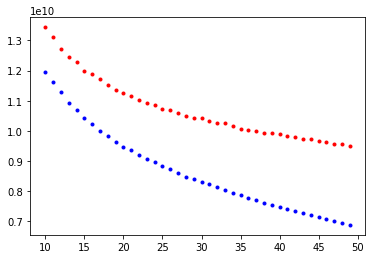

In [52]:
# plot the mean squared errors for both the training and test set
plt.plot(np.arange(10, 50), train_errors, "b.")
plt.plot(np.arange(10, 50), test_errors, "r.")


In [78]:
# create our final RandomForestRegressor, which consists of 500 
# decision trees, each with a maximum of 16 leaf nodes
rnd_reg = RandomForestRegressor(n_estimators=500, max_leaf_nodes=16,
                                n_jobs=-1, oob_score=True)

In [79]:
# train the RandomForestRegressor on our training data
rnd_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=16,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [80]:
# check the out of bag score, which gives an idea of the performance of
# our model
rnd_reg.oob_score_

0.7291355721499908

In [81]:
# check the feature importances, which measure each metric's importance
# in the processes of creating each Decision Tree
# metrics with higher values yielded purer subsets of the data when
# split upon
feature_importances = rnd_reg.feature_importances_
feature_importances

array([4.81671711e-04, 8.26406131e-03, 2.38813818e-02, 9.55164809e-02,
       1.10459897e-01, 6.40432636e-04, 7.43240915e-01, 1.46894361e-02,
       2.82572324e-03])

<Container object of 9 artists>

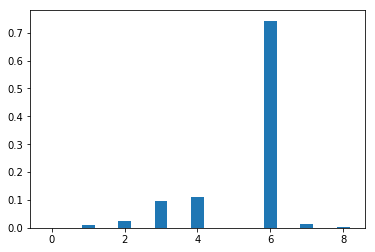

In [93]:
# Graph the feature importances

ind = np.arange(len(feature_importances))
plt.bar(ind, feature_importances, .35)

- From the graph above, we see that for the _RandomForestRegressor_, the percent of the population that was single was by and far the most important feature in the Decision Tree algorithm of splitting based on which feature yields the purest subset when split upon at a certain threshold. As we will discuss in our conclusions section, this clearly signals possible shortcomings of using blindly using Machine Learning models without considering the broader context of the data you might be analyzing.

In [58]:
# predict the new values 
y_pred = rnd_reg.predict(X_test)

In [59]:
# create a DataFrame of the test dataset, so we can compare our predictions to the actual values
df_with_predictions = pd.DataFrame(np.c_[X_test, y_test, y_pred])
df_with_predictions.columns = list(acs_df.columns) + ['homeval_pred']
df_with_predictions.head()

,pop,age,pct_male,pct_white,income,unemployment,pct_bachelors,crime_count,permit_count,homeval,homeval_pred
0,4313.0,40.4,51.124507,46.440992,74357.0,5.1,19.9,90.0,0.0,442100.0,351057.428440
1,5133.0,30.8,55.328268,30.683811,53229.0,6.1,23.9,174.0,0.0,275000.0,368672.872883
2,5707.0,48.2,52.777291,80.094621,87796.0,8.1,51.4,22.0,0.0,627700.0,566662.678144
3,3629.0,31.4,51.777349,14.439239,84688.0,8.8,22.5,59.0,0.0,333200.0,358571.784070
4,2528.0,48.3,52.531646,81.408228,97083.0,9.6,42.2,26.0,27.0,635600.0,454810.245209


### Naively Predicting Future Home Values on Fewer Metrics
- Unfortunately, some of the features that we used to train our initial model our missing from the SANDAG Forecast dataset.
- We still train a model on the remaining features as an exercise, but acknowledge that the loss of features will most likely yield a model that will make inaccurate predictions.
- We believe that our failure to create an accurate model for predicting home values signifies that the housing price regression problem in reality is multifaceted, and cannot be reduced to a linear function of population, age, and other metrics due to more advanced social factors at play.

In [34]:
# we train a model on the remaining columns:
# population, percent male, percent white, median age

# drop all other columns
acs_df_2 = acs_df[['pop', 'age', 'pct_male', 'pct_white', 'homeval']]

# get feature matrix and dependent variable column from the DataFrame
X_2 = acs_df_2.drop('homeval', axis=1).values
y_2 = acs_df_2['homeval'].values

In [35]:
# split into training set and test set
X_train_2, X_test_2, y_train_2, y_test_2 = (
  train_test_split(X_2, y_2, test_size=0.20))

In [36]:
# create our final RandomForestRegressor, which consists of 500 
# decision trees, each with a maximum of 16 leaf nodes
rnd_reg_2 = RandomForestRegressor(n_estimators=500, max_leaf_nodes=16,
                                n_jobs=-1, oob_score=True)

In [37]:
# train the RandomForestRegressor on our training data
rnd_reg_2.fit(X_train_2, y_train_2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=16,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [38]:
# Check the out-of-bag score, which is very low (40% accuracy)
rnd_reg_2.oob_score_

0.4017140697715148

In [61]:
# Read the SANDAG Forecast Data, which gives us predicted future 
# San Diego demographics with which we can predict home values,
# not accounting for regular inflation.
sandag_df = pd.read_csv('./Datasets/SANDAG_Cleaned.csv')
sandag_df = sandag_df.set_index(['year', 'tract']).sort_index()
sandag_df = sandag_df[['pop', 'age', 'male_pct', 'white_pct']]
sandag_df.head()

pop   age   male_pct  white_pct
year tract                                  
2012 1.00   3030  54.5  50.231023  85.511551
     2.01   1923  44.5  46.437858  80.187207
     2.02   4228  34.5  50.709555  74.503311
     3.00   4747  34.5  51.864335  71.729513
     4.00   3680  34.5  54.592391  65.326087

In [62]:
# Create the matrix of features that we will predict on
X_future = sandag_df.values

In [63]:
# predict the new housing values
y_2_pred = rnd_reg_2.predict(X_future)

In [64]:
# add the predicted housing values as a column to the SANDAG
# DataFrame
sandag_df_w_pred = sandag_df.reset_index()
sandag_df_w_pred['homevals_pred'] = pd.Series(y_2_pred)
sandag_df_w_pred = (sandag_df_w_pred.
                    set_index(['year', 'tract']).sort_index())
sandag_df_w_pred.head()

pop   age   male_pct  white_pct  homevals_pred
year tract                                                 
2012 1.00   3030  54.5  50.231023  85.511551  600921.303750
     2.01   1923  44.5  46.437858  80.187207  488002.002084
     2.02   4228  34.5  50.709555  74.503311  349003.680280
     3.00   4747  34.5  51.864335  71.729513  349003.680280
     4.00   3680  34.5  54.592391  65.326087  349066.721050

In [65]:
# Write the predictions DataFrame to a .csv file
sandag_df_w_pred.to_csv('sandag_df_w_pred.csv')

#### Visualizing Future San Diego Housing Prices with the SANDAG Forecast Data

![title](img/AgePost2050.png)

![title](img/PopulationPost2050.png)

![title](img/PctWhitePost2050.png)

![title](img/PctMalePost2050.png)

![title](img/HomeValuePost2050.png)

### Proposed Methods (from Project Proposal)

#### Data Cleaning
Because we explicitly defined the data we need in our research question, it is pretty straightforward to just remove the extra information. We also plan to limit our data points to a certain time period.

#### Data Analysis
To analyze the data, we actually planned on creating our own dataset, with the necessary information already extracted and combined from the datasets found online. After this cleaning, we can begin by first anonymizing the data which ensures that our potential project remains ethical in maintaining privacy of the data. Now that we’ve refined our data completely, we can begin the visualization process. We plan to start with a general scatterplot matrix, which allows us to generally see how different variables change in relation to one another. Continuing on this, other graphs such as a line graph can also provide interesting information.

Upon completion of the visualization step, we are left with a multitude of graphs and charts, all displaying important data. Our final analysis step is a simple one, which is to find the correlation. This can be done many different times, each relating two separate variables together. Correlation can be calculated using the imported matplotlib package.

#### What to report
We aim to present a correlation r that represents the strength of the relationship between our independent variables (building permits, crime rates, average age, and the percentage of white residents) and dependent variable (median income) which we used to operationalize gentrification. Along with that value, we will have graphs such as a scatterplot matrix that will help us visualize the relationships. 

Packages we plan to use:
- Numpy
- pandas
- scikitlearn
- matplotlib
- tensorflow (machine learning package)

## Privacy/Ethics Considerations

### Privacy

The data we used is from a public source and most identifying information has already been removed so it is ethical for us to use it. Our analysis will be based on data collected in a specific location and from a specific time frame. This eliminates the potential for skewed data because we’re hoping to explore these biases and see what particular information can be found for this range. If however we encounter any non anonymized data, we can follow the Safe Harbour method to remove potentially harmful or revealing information. 

### Ethics 

The goal of our project is not at all to advance any sort of claim about what most directly influences housing prices in the real world, but to apply concepts and methods learned in class to real-life data as a scientific exercise. However, the fact that we are using metrics such as percentage white population and percentage male population might put our project at risk for purposeful misinterpretation to advance certain agendas that ignore the broader context of all the societal factors that contribute to quality of life in an area. For example, if our model (or others like it) were to conclude that higher housing prices were a result of higher white and male populations, certain groups that would advocate for the existence for some sort of racial or gender-related superiority might point to and twist our model's projections as supporting their claims. 

## Conclusions and Discussion

### Discussion

If our analysis and hypotheses are indeed correct, we would have found a new method of predicting housing prices in a given area. The ability to predict such happenings can be a very useful tool for the real estate scene, politicians, and other activists vying for greater social equality. Our method of prediction, if successful, would identify the change in housing prices that our neighborhoods would go through. However, if our hypothesis is wrong, and/or our methods don’t work, then our project would still hold some value, since we would be able to conclude that the factors we chose to predict home value do not work, and that the change is probably the result of some other factors yet unconsidered. 

The largest obstacle we encountered was that our missing data. As a group, we wanted to analyze the San Diego area over a longer period of time (since 2010). However, because we were pulling information from so many different sources, we had to massively restrict our time range, which in turn restricts our data. Another problem was that we had to manually manipulate our data to match the “tracts” given in the census, since some of our data is in terms of neighborhoods, and those neighborhoods might not match across all the data sets. This, while not an extremely difficult process, still took time and energy to resolve.

#### Post-Analysis Conclusions
From the analysis, we were unable to find an accurate model because of the lack of metrics. As seen in the post 2050 visualizations, the data is extremely skewed. For example, there are several tracts which are supposedly going to be about 99% white, male, with an average age of 4 years old. We also concluded that machine learning models aren't the best predictors for complex problems like these. The model ended up saying that the most important feature was percent bachelors, which we know, by many other research studies, is not true. That being said, our project had the potential to make great changes in how we view housing prices and hopefully contributed to our society's accumulated knowledge. 
